In [12]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image as Image
import tensorflow as tf
import os
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.utils import to_categorical

### Loading the Dataset

In [26]:
dataset_path = '/content/Dataset'
sub_folders = os.listdir(dataset_path)
IMAGE_SHAPE = (224,224)
i=0
images=[]
labels=[]
path_lists=[]
temp=sub_folders

for sub_folder in sub_folders:
  sub_folder_index = temp.index(sub_folder)
  label = sub_folder_index
  if label==4:
    label=3
  path = dataset_path+'/'+sub_folder
  sub_folder_images = os.listdir(path)

  #Reading images from the subfolder one at a time
  for image in sub_folder_images:
    image_path = path+'/'+image
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image,IMAGE_SHAPE)
    path_lists.append(image_path)
    images.append(resized_image)
    labels.append(label-1)
    i+=1


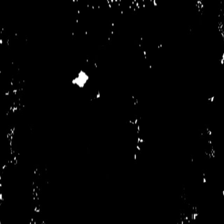

In [25]:
Image.open(str(path_lists[0])).resize(IMAGE_SHAPE)

### Data Preprocessing

In [27]:
images = np.array(images)
labels = np.array(labels)
defect_classes = ['Holes','Horizontal','Vertical']
num_of_classes = 3
classes_encoded = to_categorical(labels,num_classes = num_of_classes)

In [28]:
images = images/255.0

In [29]:
X_train,X_test,y_train,y_test = train_test_split(images,classes_encoded,test_size=0.2,random_state=10)

In [30]:
X_train.shape

(329, 224, 224, 3)

In [31]:
X_test.shape

(83, 224, 224, 3)

In [35]:
print(defect_classes[np.argmax(y_test[24])])

Vertical
